<a href="https://colab.research.google.com/github/Nov05/Google-Colaboratory/blob/master/20240213_Navigation_DuelingDQN_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **\<TOP>**

* modified by nov05 on 2024-02-13
* check [**the dueling DQN paper**, arxiv 1511.06581](https://arxiv.org/abs/1511.06581)     
* go to [the eval notebook](https://github.com/Nov05/udacity-deep-reinforcement-learning/blob/master/p1_navigation/20240211_Navigation_DQN_eval.ipynb) (run in Windows 11)   

<br>

---

* check the original DQN notebook on [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/p1_navigation)  
the dependency folder `./python` on [GitHub](https://github.com/udacity/deep-reinforcement-learning/tree/master/python)       
* refer to [the DQN notebook](https://drive.google.com/file/d/1J4tO1sFULVQ5MAhRfTz4gpThqd3_NgZR) and [other notebooks](https://gist.github.com/Nov05/4e0ff3edba96928facaff063039c7bce)  
* refer to [the Dueling DQN for pixel game](https://github.com/dxyang/DQN_pytorch/blob/master/model.py)  

<br>

---

<br>

<table>
<tr>
<th> Dueling Architecture </th>
<th> The green module </th>
</tr>
<tr>
<td>
<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/2024-02-13%2012_08_13-1511.06581.pdf.jpg?raw=true" width=300>  
</td>
<td>
<img src="https://github.com/Nov05/pictures/blob/master/Udacity/20231221_reinforcement%20learning/2024-02-13%2012_11_04-1511.06581.pdf.jpg?raw=true" width=300>
</td>
</tr>
</table>  

```text
▪️ Since both the advantage and the value stream propagate gradients to the last convolutional layer in the backward pass,
we rescale the combined gradient entering the last convolutional layer by 1/√2. This simple heuristic mildly increases stability.
▪️ In addition, we clip the gradients to have their norm less than or equal to 10. This clipping is not
standard practice in deep RL, but common in recurrent network training (Bengio et al., 2013).

```


In [ ]:
!cat /etc/*release
## Ubuntu 22.04.3 LTS (Jammy Jellyfish)

DISTRIB_ID=Ubuntu
DISTRIB_RELEASE=22.04
DISTRIB_CODENAME=jammy
DISTRIB_DESCRIPTION="Ubuntu 22.04.3 LTS"
PRETTY_NAME="Ubuntu 22.04.3 LTS"
NAME="Ubuntu"
VERSION_ID="22.04"
VERSION="22.04.3 LTS (Jammy Jellyfish)"
VERSION_CODENAME=jammy
ID=ubuntu
ID_LIKE=debian
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
UBUNTU_CODENAME=jammy


In [1]:
%%capture
## download the ""./python" folder.
## https://github.com/udacity/deep-reinforcement-learning/tree/master/python
import gdown
url = "https://drive.google.com/drive/folders/10a5WA1afaEIRgfYz7513kEc0eJTQQ1mK"
gdown.download_folder(url)

In [2]:
%%capture
## change work directory
%cd python
## get the banana build. you don't need to install ml-agents.
!wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P1/Banana/Banana_Linux.zip
!unzip Banana_Linux.zip
!rm Banana_Linux.zip

# **Navigation**   

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### **1. Start the Environment**  

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

👉 If you restart the session (Ctrl+M.), run from the following cell.  

In [3]:
# %cd python
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```



In [4]:
%%time
env = UnityEnvironment(file_name="./Banana_Linux/Banana.x86_64", no_graphics=True)

CPU times: user 21.7 ms, sys: 9.99 ms, total: 31.7 ms
Wall time: 1.11 s


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print(brain)

Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### **2. Examine the State and Action Spaces**   

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana.

Run the code cell below to print some information about the environment.

In [6]:
## reset the environment
env_info = env.reset(train_mode=True)[brain_name]
## number of agents in the environment
print('Number of agents:', len(env_info.agents))
## number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
## examine the state space
state = env_info.vector_observations[0]
print('States look like:\n', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like:
 [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### **3. Take Random Actions in the Environment**  

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
# %%time
# env_info = env.reset(train_mode=False)[brain_name] # reset the environment
# state = env_info.vector_observations[0]            # get the current state
# score = 0                                          # initialize the score
# while True:
#     action = np.random.randint(action_size)        # select an action
#     env_info = env.step(action)[brain_name]        # send the action to the environment
#     next_state = env_info.vector_observations[0]   # get the next state
#     reward = env_info.rewards[0]                   # get the reward
#     done = env_info.local_done[0]                  # see if episode has finished
#     score += reward                                # update the score
#     state = next_state                             # roll over the state to next time step
#     if done:                                       # exit loop if episode finished
#         break
# print("Score: {}".format(score))
# # env.close()
# ## Wall time: 29.8 s

When finished, you can close the environment.

### **4. It's Your Turn!**  

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```  


#### **class QNetwork**  

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        "*** YOUR CODE HERE ***"
        self.layer1 = nn.Linear(state_size, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3_adv = nn.Linear(in_features=64, out_features=action_size) ## advantage
        self.layer3_val = nn.Linear(in_features=64, out_features=1) ## state value

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.layer1(state))
        x = F.relu(self.layer2(x))
        adv, val = self.layer3_adv(x), self.layer3_val(x)
        # print(val.shape, adv.shape, adv.mean(1).shape,
        #       adv.mean(1).unsqueeze(1).expand(x.size(0), action_size).shape)
        return (val + adv - adv.mean(1).unsqueeze(1).expand(x.size(0), action_size)) / (2**0.5)

In [39]:
# ## verify tensor shapes
# ## e.g. torch.Size([1, 1]) torch.Size([1, 4]) torch.Size([1]) torch.Size([1, 4])
# ##      tensor([[-0.0165,  0.0439, -0.0170, -0.0675]], grad_fn=<DivBackward0>)
# import numpy as np
# qnetwork = QNetwork(37, 4, 0)
# state = np.random.rand(37)
# state = torch.from_numpy(state).float().unsqueeze(0)
# qnetwork.forward(state)

#### **class ReplayBuffer**     

In [40]:
import numpy as np
import random
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e])).float().to(device) ## aka. observations
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

#### **class Agent**  

In [41]:
class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)

        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.

        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        target_j = reward_j + gamma * max_a ()

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1-dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        ## clip the gradients
        nn.utils.clip_grad_norm_(self.qnetwork_local.parameters(), 10.)
        nn.utils.clip_grad_norm_(self.qnetwork_target.parameters(), 10.)

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [42]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
# print(agent.qnetwork_local)
for param in list(agent.qnetwork_local.parameters()):
    print(param.shape)

torch.Size([64, 37])
torch.Size([64])
torch.Size([64, 64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])
torch.Size([1, 64])
torch.Size([1])


**Benchmark Implementation**  

In case you get stuck, note that you should be able to solve the project by making only minor modifications to the DQN code provided as part of the Deep Q-Networks lesson. Please see the image below for an example of how you might expect your agent's score to evolve. If you're interested in about how long it should take, in the solution code for the project, we were able to solve the project **in fewer than 1800 episodes**.

#### **function train()**

In [43]:
%%time
import sys
from tqdm import tqdm

def train(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.

    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    score_max = float('-inf')
    is_solved = False
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
    # for i_episode in tqdm(range(1, n_episodes+1), desc="Episodes", position=0, leave=True):
        state = env.reset(train_mode=True)[brain_name].vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations[0], \
                                       env_info.rewards[0], env_info.local_done[0]
            agent.step(state, action, reward, next_state, done) ## learn every UPDATE_EVERY = 4 steps
            state = next_state
            score += reward
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100==0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        scores_mean = np.mean(scores_window)
        if scores_mean>=20. and scores_mean>score_max:
            score_max = scores_mean
            if not is_solved:
                is_solved = True
                print('\nEnvironment solved in {:d} episodes!'.format(i_episode-100))
            print("\nCheckpoint is saved at episode {:d}, average score: {:.2f}".format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), f'checkpoint_{i_episode}.pth')
    return scores

scores = train()

Episode 100	Average Score: 0.41
Episode 200	Average Score: 2.81
Episode 300	Average Score: 6.19
Episode 400	Average Score: 9.32
Episode 500	Average Score: 13.57
Episode 600	Average Score: 15.33
Episode 700	Average Score: 15.67
Episode 800	Average Score: 15.87
Episode 900	Average Score: 16.20
Episode 1000	Average Score: 16.47
Episode 1100	Average Score: 16.46
Episode 1200	Average Score: 17.12
Episode 1300	Average Score: 16.46
Episode 1400	Average Score: 16.58
Episode 1500	Average Score: 16.43
Episode 1600	Average Score: 15.84
Episode 1700	Average Score: 16.37
Episode 1800	Average Score: 17.03
Episode 1900	Average Score: 17.03
Episode 2000	Average Score: 17.03
CPU times: user 31min 45s, sys: 1min 57s, total: 33min 43s
Wall time: 45min 39s


Tesla T4, linear_256_64:  
2000 episodes, avg score around 15  
Wall time: 29min 39s  

In [44]:
## since the training didn't reach 20, the desired score, no checkpoint has been automatically save.
## manually save the model weights.
torch.save(agent.qnetwork_local.state_dict(), f'dqn_checkpoint_2000.pth')

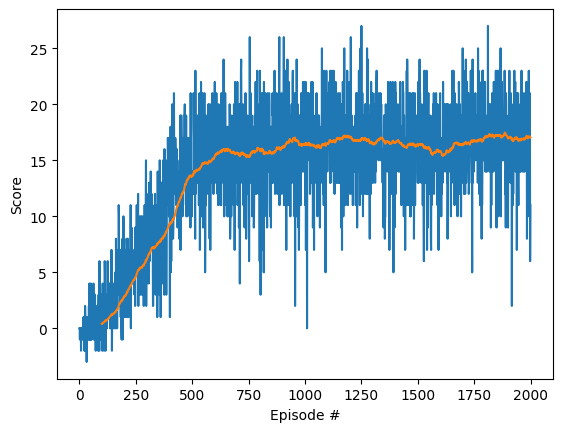

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.plot(np.arange(len(scores)), pd.DataFrame(scores).rolling(window=100).mean())
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# **\<BOTTOM>**  